In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
from typing import List, Tuple, Dict, Any
import eval_repeatability as er
import config_repeatability as cfg_rep
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
detector_name='tilde'

In [3]:
dir_output = '../../output_evaluation/detectors'
fp_output = os.path.join(dir_output, '{}.pkl'.format(detector_name))

### Lade Daten

In [4]:
with open(fp_output, 'rb') as src:
    data = pickle.load(src, encoding='utf-8')

### Hilfsfunktionen

In [5]:
def stats__num_kpts(
    collection_name:str, 
    set_name:str, 
    data:Dict, 
    config:Dict, 
    fs:Dict) -> None:
    """Erstelle Meta-Metriken zur Anzahl gefundener Kepunkte 
    innerhalb eines Sets."""
    stats = data[collection_name][set_name]['stats_num_kpts']
    print('{} - {}/{}:'.format(config['detector_name'], collection_name, set_name))
    print('durchschnittliche Anzahl Keypunkte:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Anzahl gefundener Keypunkte:\t\t', stats['val_max'])
    print('min. Anzahl gefundener Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])
    

In [6]:
def stats_set__perc_matching_kpts_for_e(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    stats = data[collection_name][set_name]['stats_perc_matching_kpts_for_e_{}'.format(epsilon)]
    
    print('{}: {}/{}'.format(config['detector_name'], collection_name, set_name))
    print('durchschnittliche Prozent an gematchen Keypunkten:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Prozent gematchter Keypunkte:\t\t', stats['val_max'])
    print('min. Prozent gematchter Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])


In [7]:
def stats_collection__num_kpts(
    collection_name:str,
    data:Dict,
    config:Dict,
    fs:Dict) -> None:
    stats = data[collection_name]['stats_num_kpts']
    
    print('{}: {}'.format(config['detector_name'], collection_name))
    print('durchschnittliche Anzahl gefundener Keypunkten:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Anzahl gefundener Keypunkte:\t\t', stats['val_max'])
    print('min. Anzahl gefundener Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])


In [8]:
def stats_collection__perc_matching_kpts_for_e(
    collection_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    stats = data[collection_name]['stats_perc_matching_kpts_for_e_{}'.format(epsilon)]
    
    print('{}: {}'.format(config['detector_name'], collection_name))
    print('durchschnittliche Prozent an gematchen Keypunkten:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Prozent gematchter Keypunkte:\t\t', stats['val_max'])
    print('min. Prozent gematchter Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])


### Plot Funktionen

In [9]:
def plot_example_images(
    collection_name:str, 
    set_name:str, 
    config:Dict, 
    fs:Dict,
    direction:str='horizontal'): # alternative: 'vertical'
    image_dir = os.path.join(config['image_dir'], collection_name, set_name)
    image_names = os.listdir(image_dir)
    
    _image_names = [image_names[0], 
                 image_names[int(0.5 * len(image_names))], 
                 image_names[-1]]

    _imgs = []
    for _image_name in _image_names:
        img = cv2.imread(os.path.join(image_dir, _image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        _imgs.append(img)
    
    if direction == 'horizontal':
        plt.rcParams['figure.figsize'] = [16, 4]
        fig, axes = plt.subplots(nrows=1, ncols=3)
    else:
        plt.rcParams['figure.figsize'] = [16, 6]
        fig, axes = plt.subplots(nrows=3, ncols=1)
        
    fig.suptitle('Beispielbilder aus dem Set {}'.format(set_name), fontsize=16)
    for idx, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(_imgs[idx])

In [10]:
def plot_num_kpts(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict
    ) -> None:
    plt.rcParams['figure.figsize'] = [16, 9]
    stats = data[collection_name][set_name]['stats_num_kpts']
    y = stats['y']
    x = list(range(len(y)))

    # Find min/max values and their indices in y.
    idx_min = stats['idx_min']
    idx_max = stats['idx_max']
    val_min = stats['val_min']
    val_max = stats['val_max']

    # Get average and standard deviation.
    avg = stats['avg']
    std = stats['std']

    fig, ax = plt.subplots(nrows=1, ncols=1)

    # Plot number of keypoints.
    ax.bar(x, y, color='C0')
    ax.bar(stats['idx_extrema_lt_std'], stats['val_extrema_lt_std'], color='navy')
    ax.bar(stats['idx_extrema_gt_std'], stats['val_extrema_gt_std'], color='navy')

    # Draw average and standard devation.
    ax.axhline(y=avg, color='orange', label='mean')
    ax.axhline(y=avg + std, color='orange', linestyle=':', alpha=1)
    ax.axhline(y=avg - std, color='orange', linestyle=':', alpha=1)

    if val_min == val_max:
        ax.text(
        idx_max - 0.125, 
        val_max - int(val_max / 20),
        'max/max: {}'.format(val_max),
        color='white',
        rotation=90);

    else:
        # insert max value text
        ax.text(
            idx_max - 0.125, 
            val_max - int(val_max / 20),
            'max: {}'.format(val_max),
            color='white',
            rotation=90);

        # insert min value text
        ax.text(
            idx_min - 0.125, 
            val_min - int(val_min / 10), 
            'min: {}'.format(val_min),
            color='white',
            rotation=90);

    ax.set_title('{} - Anzahl gefundener Keypunkte für das Set {}.'.format(config['detector_name'], set_name))
    ax.set_ylabel('Anzahl gefundener Keypunkte in Bild i');
    ax.set_xlabel('Das i-te Bild');

In [11]:
def plot_extrema_images(
    collection_name:str, 
    set_name:str, 
    data:Dict, 
    config:Dict, 
    fs:Dict,
    direction:str='horizontal') -> None:
    """Shows the two images with the most and with least number
    of keypoints."""
    
    y = data[collection_name]['num_kpts'].loc[fs[collection_name][set_name]].values.flatten()
    image_dir = os.path.join(config['image_dir'], collection_name, set_name)
    kpts_image_names = sorted([config['kpts_image_format'].format(x[:-4], config['max_size']) for x in os.listdir(image_dir)])

    data_dir = os.path.join(config['data_dir'], collection_name, set_name, 'keypoint_images', detector_name)
    idx_min = np.argmin(y)
    idx_max = np.argmax(y)
    
    # If min and max are the same, but there are also other entries
    # with the same max value, take the next one.
    if idx_min == idx_max:
        _maxes = np.where(y == np.max(y))[0].flatten()
        if len(_maxes) > 1:
            idx_max = _maxes[1]

    titles = ['{} - Bild mit wenigsten Keypunkten ({})', '{} -Bild mit meisten Keypunkten ({})']
    num_kpts = [y[idx_min], y[idx_max]]
    image_names = [kpts_image_names[idx_min], kpts_image_names[idx_max]]

    images = []
    for image_name in image_names:
        img = cv2.imread(os.path.join(data_dir, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    if direction == 'horizontal':
        plt.rcParams['figure.figsize'] = [16, 16]
        fig, axes = plt.subplots(nrows=1, ncols=2)
    else:
        plt.rcParams['figure.figsize'] = [16, 6]
        fig, axes = plt.subplots(nrows=2, ncols=1)
    
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i].format(config['detector_name'], num_kpts[i]))

In [12]:
def plot_repeatability_heatmap(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    heatmap = data[collection_name][set_name]['perc_matching_kpts_for_e_1'].values
    
    plt.rcParams['figure.figsize'] = [10, 10]    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    im = ax.imshow(heatmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax);
    
    ax.set_title('{} - Prozentuale Wiederholbarkeit für alle Bildpaare.'.format(config['detector_name']))

In [13]:
def plot_set__repeatability_for_e(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    # Finde für jedes Bild i die durchschnittliche Prozenteanzahl
    # an gematchten Keypunkten mit jedem anderen Bild j, (i != j).
    plt.rcParams['figure.figsize'] = [16, 9]
    
    stats = data[collection_name][set_name]['stats_perc_matching_kpts_for_e_{}'.format(epsilon)]
    
    y = stats['y']
    avg = stats['avg']
    std = stats['std']

    fig, ax = plt.subplots(nrows=1, ncols=1)
    for r in stats['rows']:
        ax.plot(r, alpha=0.1)
    ax.plot(y)
    
    ax.axhline(avg, label='{0:.2f}'.format(avg), color='orange')
    ax.axhline(y=avg+std, color='orange', linestyle=':')
    ax.axhline(y=avg-std, color='orange', linestyle=':')
    
    ax.legend();
    
    ax.set_title('{} - Durchschnittliche Wiederholbarkeit der Keypunktsets.'.format(config['detector_name']))

In [14]:
def plot_collection__stats_num_kpts_for_e(
    collection_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    stats = data[collection_name]['stats_num_kpts_for_e_{}'.format(epsilon)]
    set_names = stats['set_names']
    x = range(len(stats['set_names']))
    y = stats['y']
    avg = stats['avg']
    std = stats['std']

    val_min = stats['val_min']
    val_max = stats['val_max']
    idx_max = stats['idx_max']
    idx_min = stats['idx_min']

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.bar(set_names, y, color='C0')
    ax.bar(stats['idx_extrema_lt_std'], stats['val_extrema_lt_std'], color='navy')
    ax.bar(stats['idx_extrema_gt_std'], stats['val_extrema_gt_std'], color='navy')


    ax.axhline(avg, color='orange', label='{}'.format(avg))
    ax.axhline(avg -std, color='orange', linestyle=':')
    ax.axhline(avg + std, color='orange', linestyle=':')

    ax.legend()

    if val_min == val_max:
        ax.text(
        idx_max - 0.5, 
        val_max - int(val_max / 20),
        'max/max: {}'.format(val_max),
        color='white',
        rotation=90);

    else:
        # insert max value text
        ax.text(
            idx_max - 0.3, 
            val_max - int(avg / 20),
            'max: {}'.format(val_max),
            color='white');

        # insert min value text
        ax.text(
            idx_min - 0.3, 
            val_min - int(avg / 20), 
            'min: {}'.format(val_min),
            color='white');

    ax.set_title('{} - Durchschnittliche Anzahl gefundener Keypunkte für alle Sets  in Kollection {}.'.format(config['detector_name'], collection_name))
    ax.set_ylabel('Anzahl durchschnittlich gefundener Keypunkte in Bild i');
    ax.set_xlabel('Das i-te Set');

In [15]:
def plot_collection__stats_perc_matching_kpts_for_e(
    collection_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    stats = data[collection_name]['stats_perc_matching_kpts_for_e_{}'.format(epsilon)]
    set_names = stats['set_names']
    y = stats['y']
    avg = stats['avg']
    std = stats['std']

    val_min = stats['val_min']
    val_max = stats['val_max']
    idx_max = stats['idx_max']
    idx_min = stats['idx_min']

    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.bar(set_names, y, color='C0')
    ax.bar(stats['idx_extrema_lt_std'], stats['val_extrema_lt_std'], color='navy')
    ax.bar(stats['idx_extrema_gt_std'], stats['val_extrema_gt_std'], color='navy')


    ax.axhline(avg, color='orange', label='{0:.4f}'.format(avg))
    ax.axhline(avg - std, color='orange', linestyle=':')
    ax.axhline(avg + std, color='orange', linestyle=':')

    ax.legend()

    if val_min == val_max:
        ax.text(
        idx_max - 0.5, 
        val_max - val_max / 20,
        'max/max: {0:.4f}'.format(val_max),
        color='white',
        rotation=90);

    else:
        # insert max value text
        ax.text(
            idx_max - 0.3, 
            val_max - avg / 20,
            'max: {0:.4f}'.format(val_max),
            color='white');

        # insert min value text
        ax.text(
            idx_min - 0.3, 
            val_min - avg / 20,
            'min: {0:.4f}'.format(val_min),
            color='white');

    ax.set_title('{} - Durchschnittliche Prozent gematchter Keypunkte für alle Sets in Kollection {}.'.format(config['detector_name'], collection_name))
    ax.set_ylabel('Prozent durchschnittlich gematchter Keypunkte');
    ax.set_xlabel('Das i-te Set');

### Konfiguration

In [16]:
config = data['_meta']['config']
fs = data['_meta']['file_system']
detector_name = 'sift'
collection_name = 'webcam'

### Set Chamonix

In [17]:
set_name = 'chamonix'

Zeige drei Bilder aus dem Set. Das erste, letzte und eins in der Mitte.

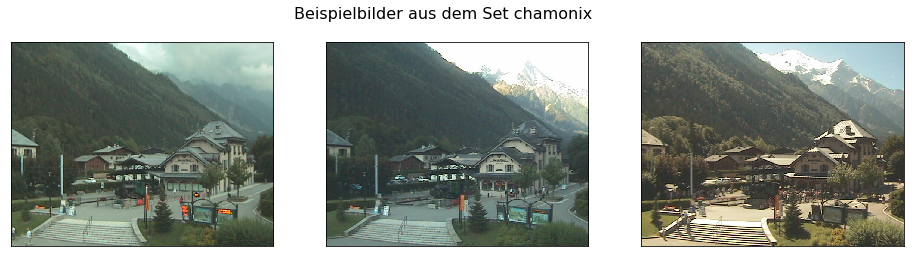

In [18]:
plot_example_images(collection_name, set_name, config, fs)

Zeigt die Anzahl der gefundenen Keypunkte für jedes Bild innerhalb des Sets an. 
Die orange Linie zeigt die durchschnittliche Anzahl gefundener Keypunkte in dem Set an.
Die orange, gepunktete Linie repräsentiert den Durchschnitt plus/minus der Standardabweichung. 
Dunkler markierte Balken liegen außerhalb der doppelten Standardabweichung.

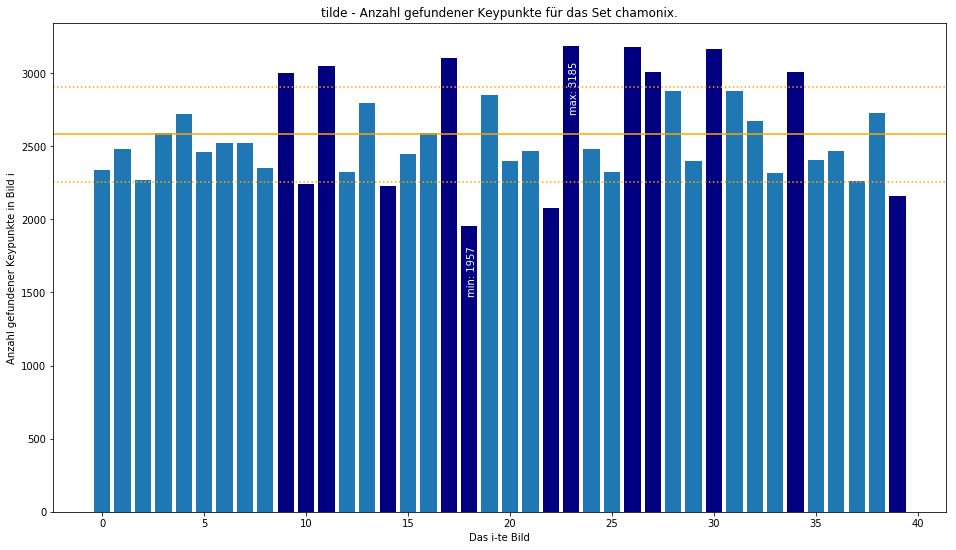

In [19]:
plot_num_kpts(collection_name, set_name, data, config, fs)

Dies sind die Statistiken der oben gezeigten Graphik.

In [20]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/chamonix:
durchschnittliche Anzahl Keypunkte:		2581.05+/-323.48
max. Anzahl gefundener Keypunkte:		 3185
min. Anzahl gefundener Keypunkte:		 1957
Anzahl an Extrema:				 13
	davon oberhalb Standardabweichung:	 8
	davon unterhalb Standardabweichung:	 5


Ein Beispiel für die unterschiedliche Anzahl gefundener Keypunnkte.

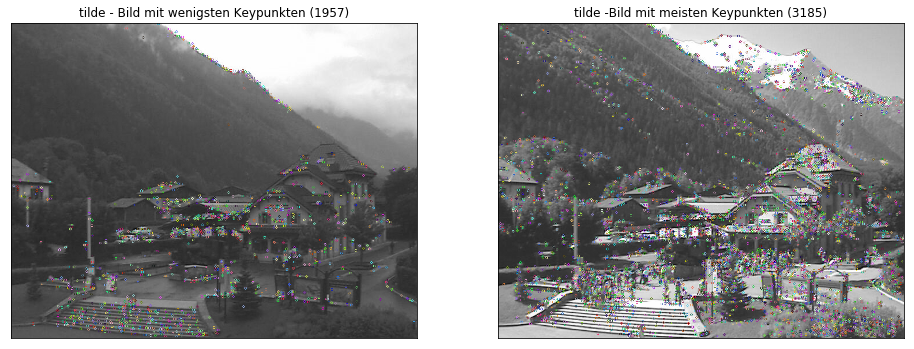

In [21]:
plot_extrema_images(collection_name, set_name, data, config, fs)

Gibt den Prozentsatz an, mit dem die Keypunkte des Bildes $img_i$ im Partnerbild $img_j$ gefunden wurden.
Die Diagonale stellt dabei das Bildpaar $(img_i, img_j)$ da mit $i = j$, worin natürlich stets alle Keypunkte wiedergefunden werden.

In [22]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

Zeigt die durchschnittliche Wiederholbarkeit, bzw. Wiederfindbarkeit von Keypunkten.
Für jedes Bild $img_i$ existiert ein leicht durchsichtiger Graph, der die prozentuelle Wiederholbarkeit der Keypunkte im Bild $img_i$ in dem Bildpaar $(img_i, img_j)$ angibt.
Der Durchschnitt dieser Werte ist in der dunkelblauen Linie sichtbar und gibt den durchschnittliche Wiederholbarkeit der Keypunkte in Bild $(img_i)$ an.
Die orange Linie stellt die prozentuale Wiederholbarkeit des Detektors auf diesem Set da. Der Wert ist oben rechts in der Legende ersichtlich.

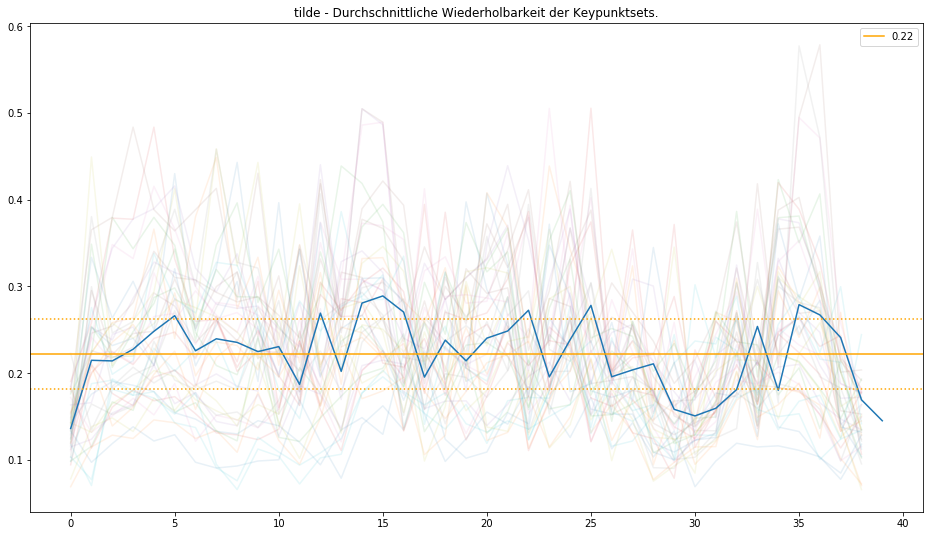

In [23]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [24]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/chamonix
durchschnittliche Prozent an gematchen Keypunkten:		0.22+/-0.04
max. Prozent gematchter Keypunkte:		 0.28892374
min. Prozent gematchter Keypunkte:		 0.13607202
Anzahl an Extrema:				 17
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 8


### Set Courbevoie

In [25]:
set_name = 'courbevoie'

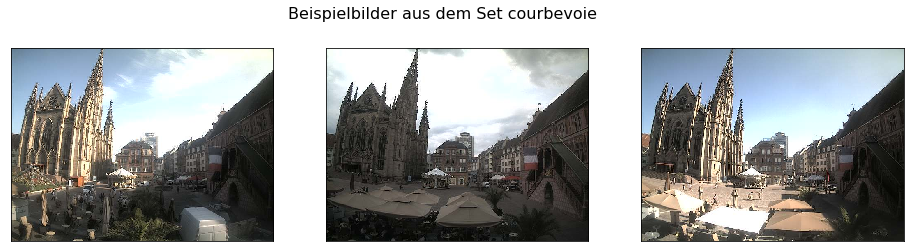

In [26]:
plot_example_images(collection_name, set_name, config, fs)

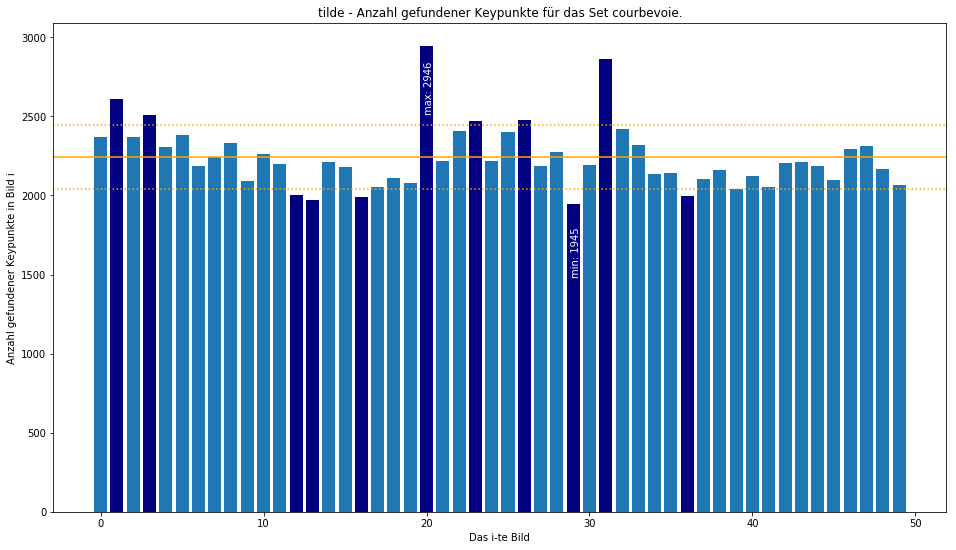

In [27]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [28]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/courbevoie:
durchschnittliche Anzahl Keypunkte:		2241.86+/-200.88
max. Anzahl gefundener Keypunkte:		 2946
min. Anzahl gefundener Keypunkte:		 1945
Anzahl an Extrema:				 11
	davon oberhalb Standardabweichung:	 6
	davon unterhalb Standardabweichung:	 5


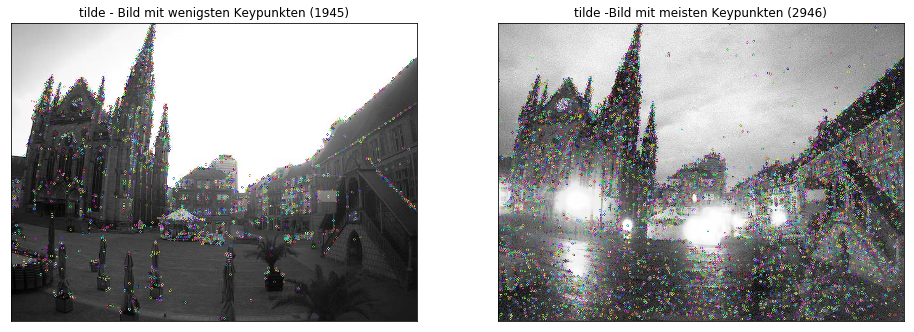

In [29]:
plot_extrema_images(collection_name, set_name, data, config, fs)

In [30]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

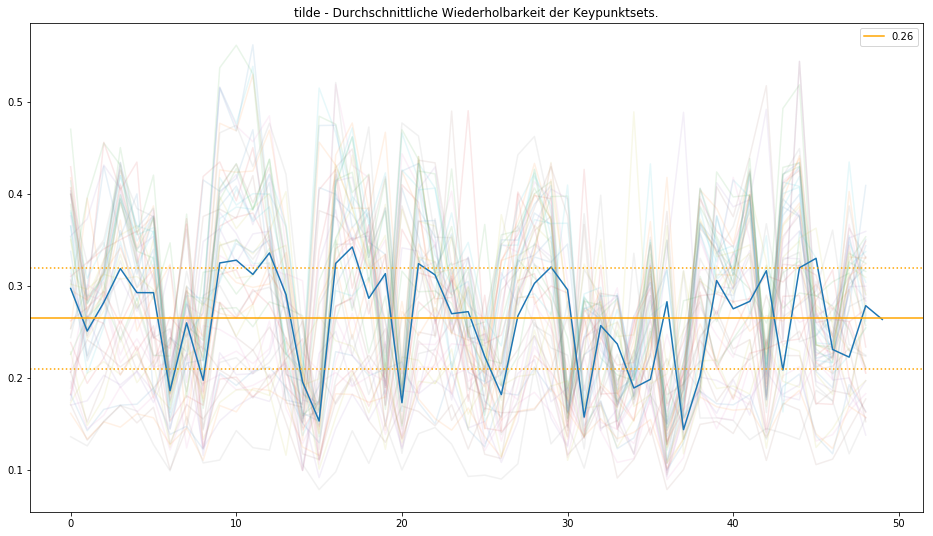

In [31]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [32]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/courbevoie
durchschnittliche Prozent an gematchen Keypunkten:		0.26+/-0.05
max. Prozent gematchter Keypunkte:		 0.34208527
min. Prozent gematchter Keypunkte:		 0.1434871
Anzahl an Extrema:				 21
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 12


### Set Frankurt

In [33]:
set_name = 'frankfurt'

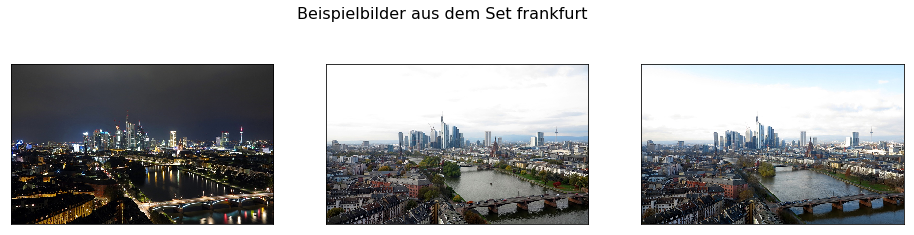

In [34]:
plot_example_images(collection_name, set_name, config, fs)

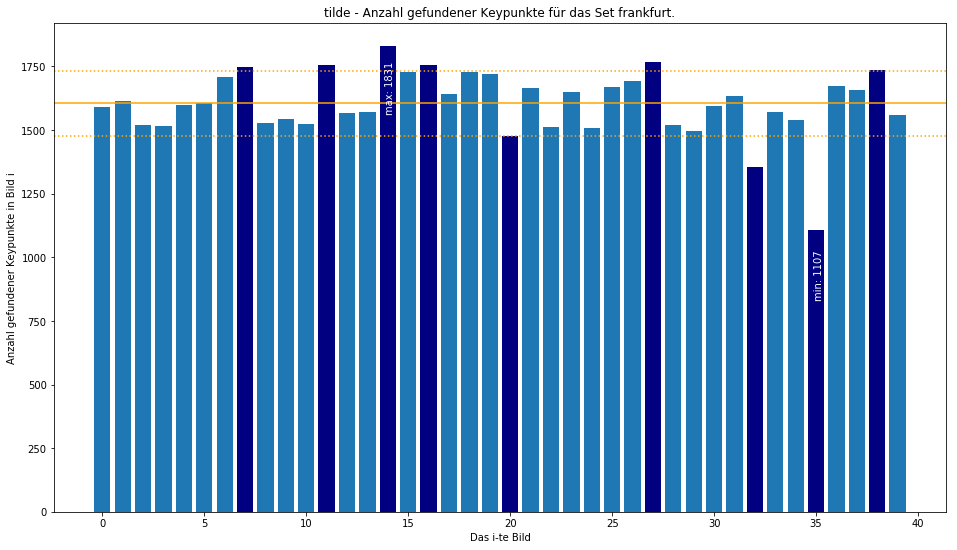

In [35]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [36]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/frankfurt:
durchschnittliche Anzahl Keypunkte:		1604.58+/-127.58
max. Anzahl gefundener Keypunkte:		 1831
min. Anzahl gefundener Keypunkte:		 1107
Anzahl an Extrema:				 9
	davon oberhalb Standardabweichung:	 6
	davon unterhalb Standardabweichung:	 3


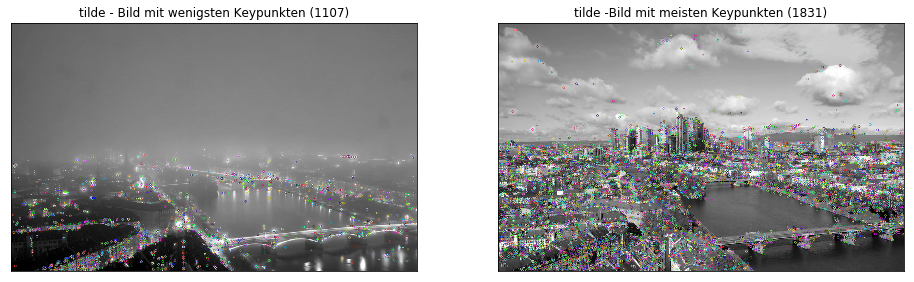

In [37]:
plot_extrema_images(collection_name, set_name, data, config, fs)

In [38]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

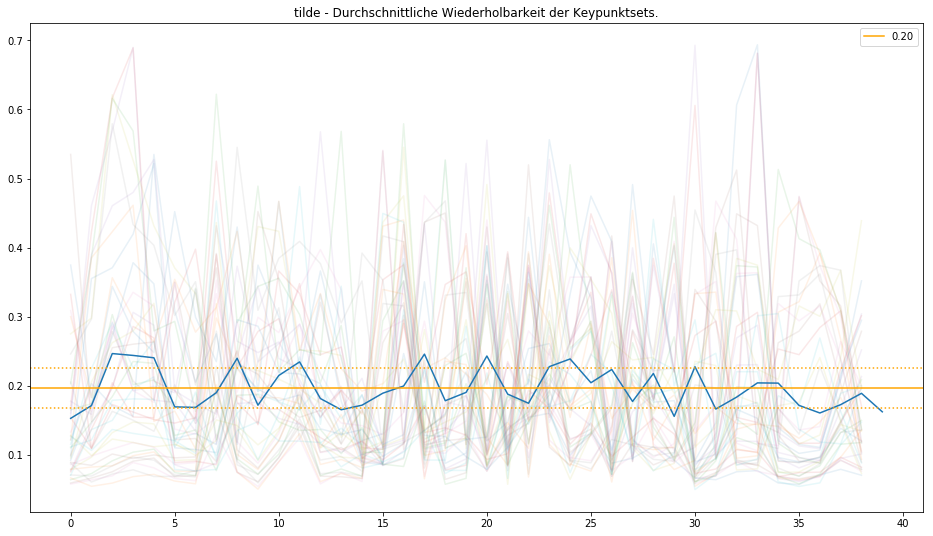

In [39]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [40]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/frankfurt
durchschnittliche Prozent an gematchen Keypunkten:		0.20+/-0.03
max. Prozent gematchter Keypunkte:		 0.24629514
min. Prozent gematchter Keypunkte:		 0.15240107
Anzahl an Extrema:				 16
	davon oberhalb Standardabweichung:	 10
	davon unterhalb Standardabweichung:	 6


### Set Mexico

In [41]:
set_name = 'mexico'

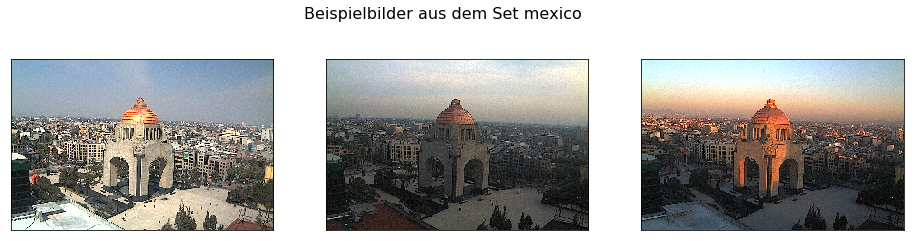

In [42]:
plot_example_images(collection_name, set_name, config, fs)

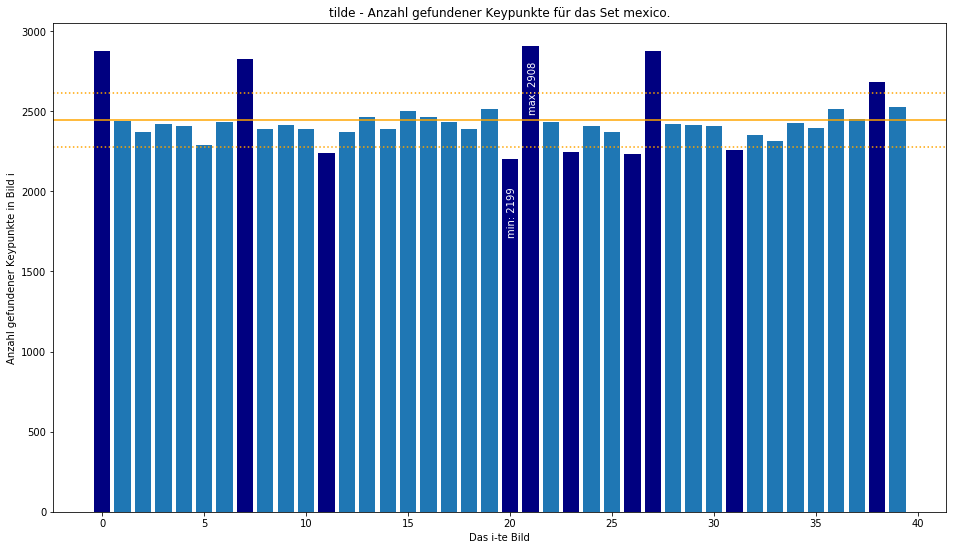

In [43]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [44]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/mexico:
durchschnittliche Anzahl Keypunkte:		2446.88+/-167.14
max. Anzahl gefundener Keypunkte:		 2908
min. Anzahl gefundener Keypunkte:		 2199
Anzahl an Extrema:				 10
	davon oberhalb Standardabweichung:	 5
	davon unterhalb Standardabweichung:	 5


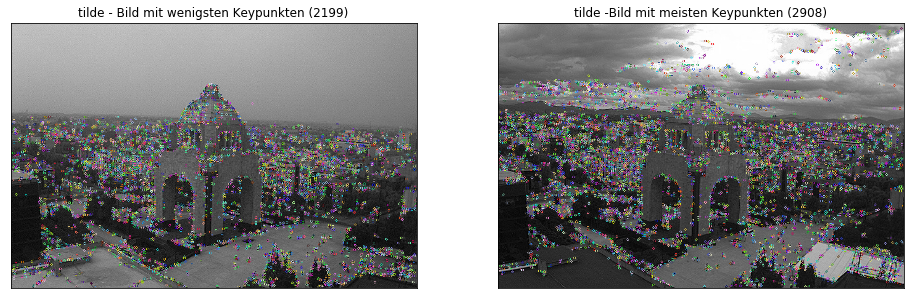

In [45]:
plot_extrema_images(collection_name, set_name, data, config, fs)

In [46]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

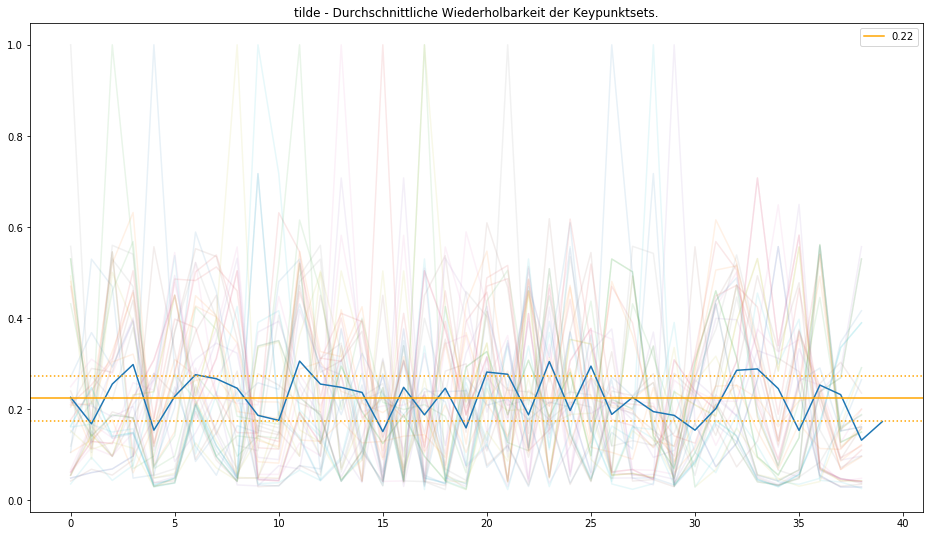

In [47]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [48]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/mexico
durchschnittliche Prozent an gematchen Keypunkten:		0.22+/-0.05
max. Prozent gematchter Keypunkte:		 0.30583692
min. Prozent gematchter Keypunkte:		 0.13222826
Anzahl an Extrema:				 17
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 8


### Set Panorama

In [49]:
set_name = 'panorama'

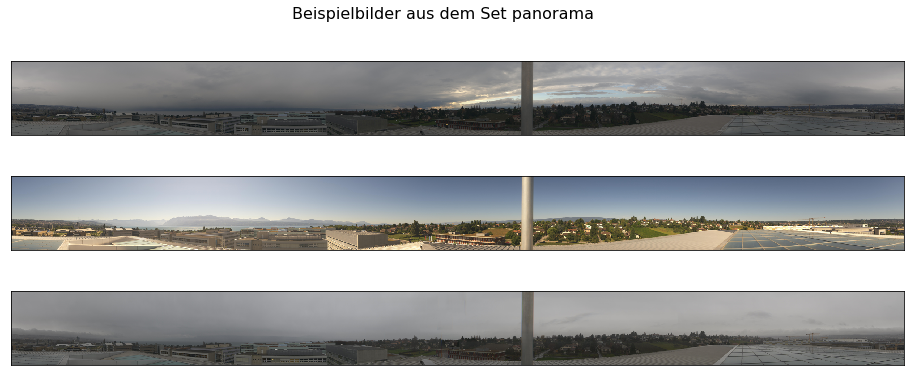

In [50]:
plot_example_images(collection_name, set_name, config, fs, direction='vertical')

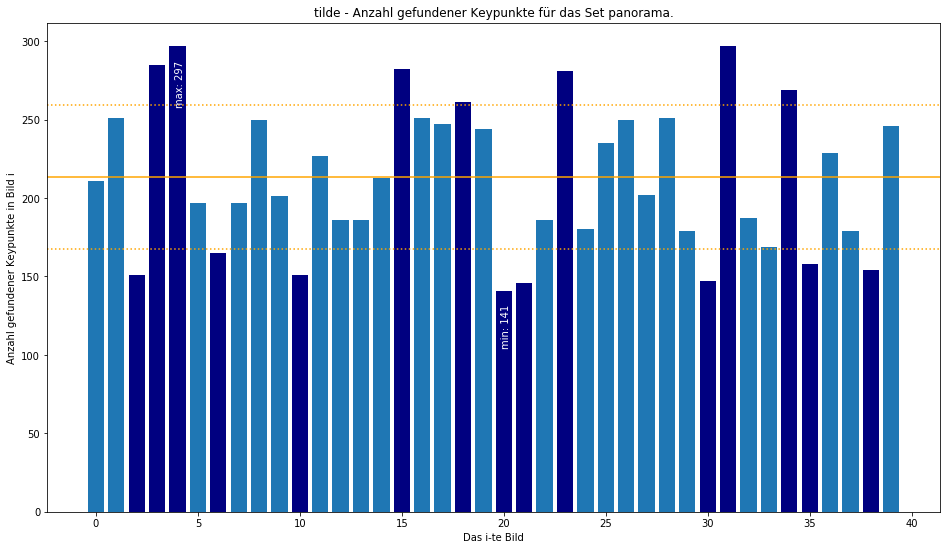

In [51]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [52]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/panorama:
durchschnittliche Anzahl Keypunkte:		213.47+/-46.05
max. Anzahl gefundener Keypunkte:		 297
min. Anzahl gefundener Keypunkte:		 141
Anzahl an Extrema:				 15
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 8


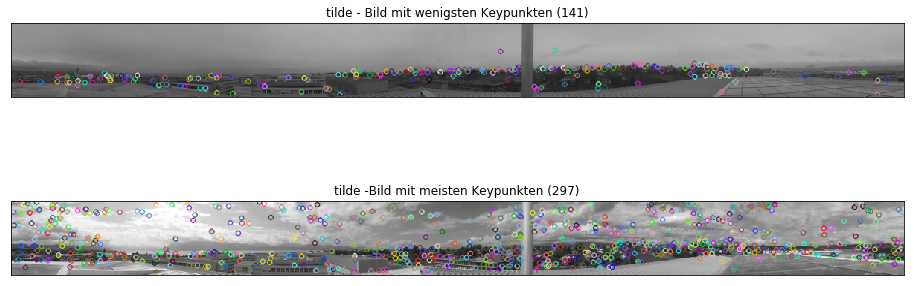

In [53]:
plot_extrema_images(collection_name, set_name, data, config, fs, direction='vertical')

In [54]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

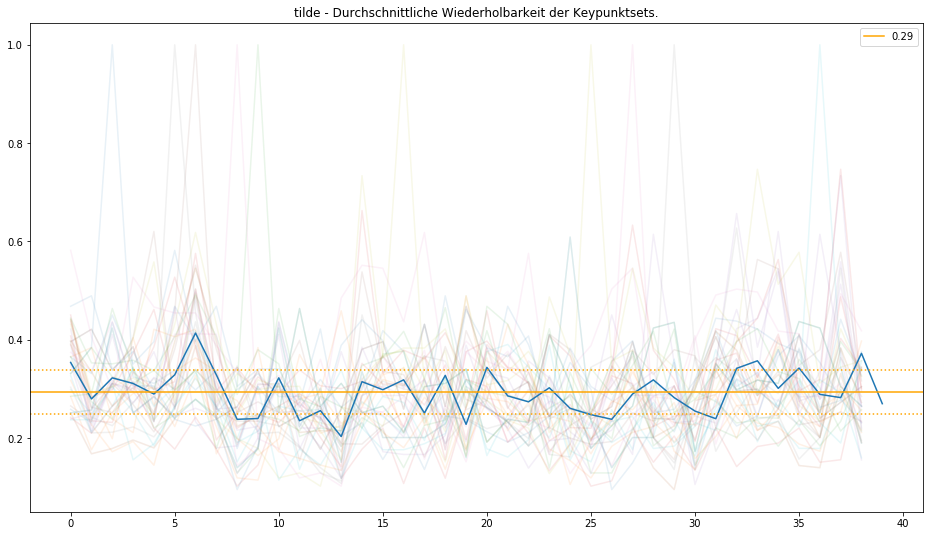

In [55]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [56]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/panorama
durchschnittliche Prozent an gematchen Keypunkten:		0.29+/-0.04
max. Prozent gematchter Keypunkte:		 0.41352552
min. Prozent gematchter Keypunkte:		 0.20311373
Anzahl an Extrema:				 15
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 8


### Set St. Louis

In [57]:
set_name = 'stlouis'

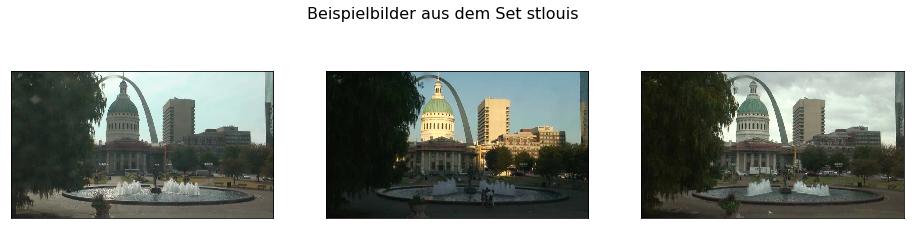

In [58]:
plot_example_images(collection_name, set_name, config, fs)

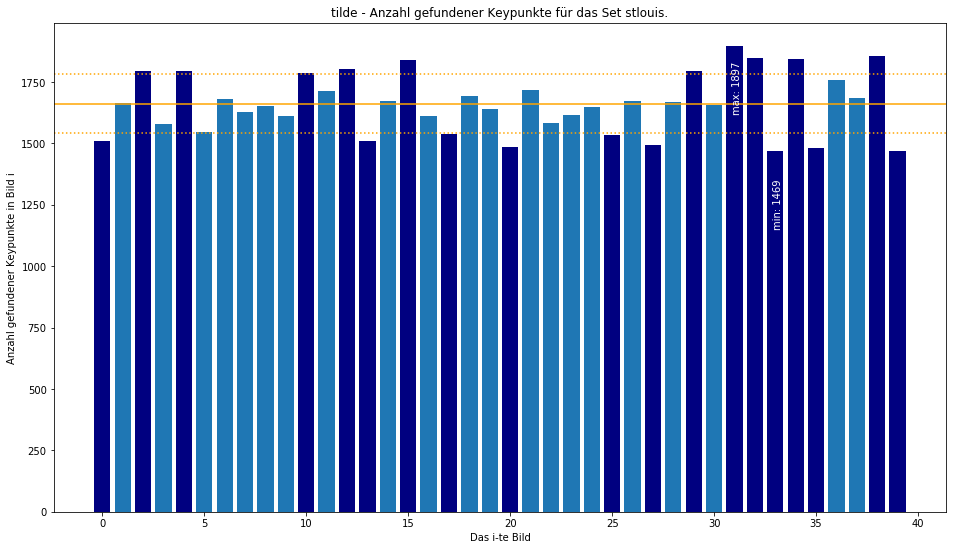

In [59]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [60]:
stats__num_kpts(collection_name, set_name, data, config, fs)

tilde - webcam/stlouis:
durchschnittliche Anzahl Keypunkte:		1661.10+/-120.22
max. Anzahl gefundener Keypunkte:		 1897
min. Anzahl gefundener Keypunkte:		 1469
Anzahl an Extrema:				 19
	davon oberhalb Standardabweichung:	 10
	davon unterhalb Standardabweichung:	 9


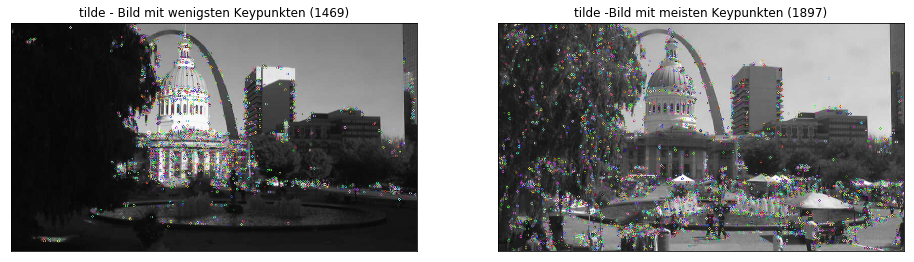

In [61]:
plot_extrema_images(collection_name, set_name, data, config, fs)

In [62]:
#plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

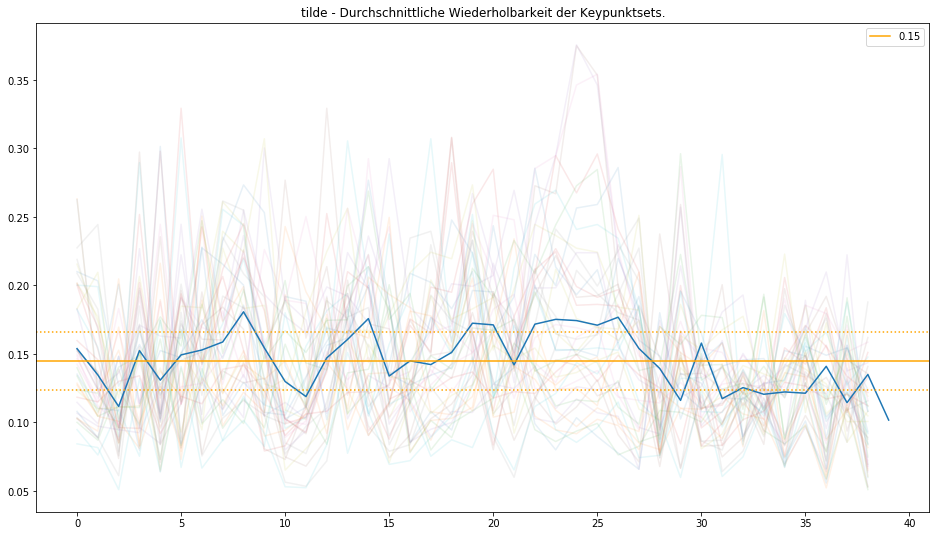

In [63]:
plot_set__repeatability_for_e(collection_name,  set_name, data, config, fs)

In [64]:
stats_set__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

tilde: webcam/stlouis
durchschnittliche Prozent an gematchen Keypunkten:		0.15+/-0.02
max. Prozent gematchter Keypunkte:		 0.18078737
min. Prozent gematchter Keypunkte:		 0.101761185
Anzahl an Extrema:				 18
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 9


### Zusammenfassung

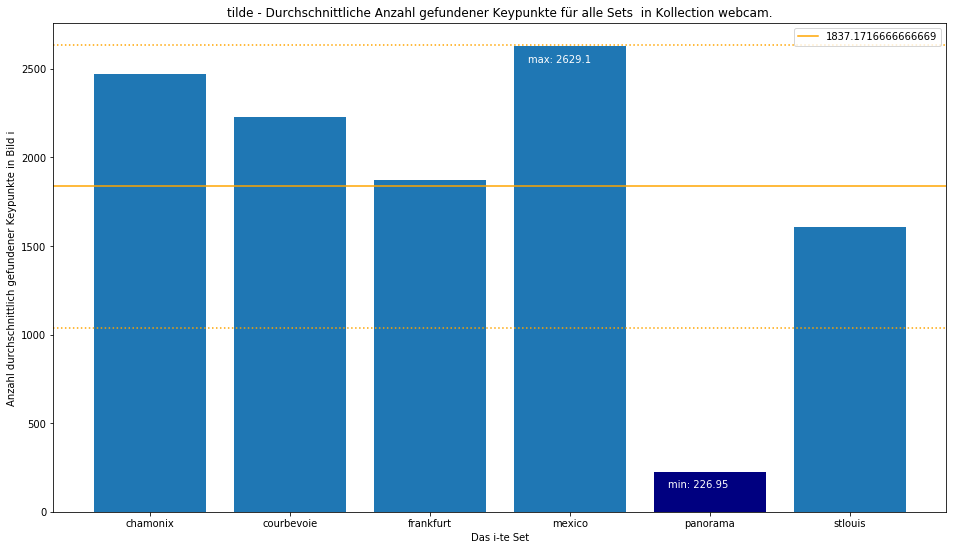

In [65]:
plot_collection__stats_num_kpts_for_e(collection_name, data, config, fs)

In [66]:
stats_collection__num_kpts(collection_name, data, config, fs)

tilde: webcam
durchschnittliche Anzahl gefundener Keypunkten:		1791.49+/-795.60
max. Anzahl gefundener Keypunkte:		 2581.05
min. Anzahl gefundener Keypunkte:		 213.475
Anzahl an Extrema:				 1
	davon oberhalb Standardabweichung:	 0
	davon unterhalb Standardabweichung:	 1


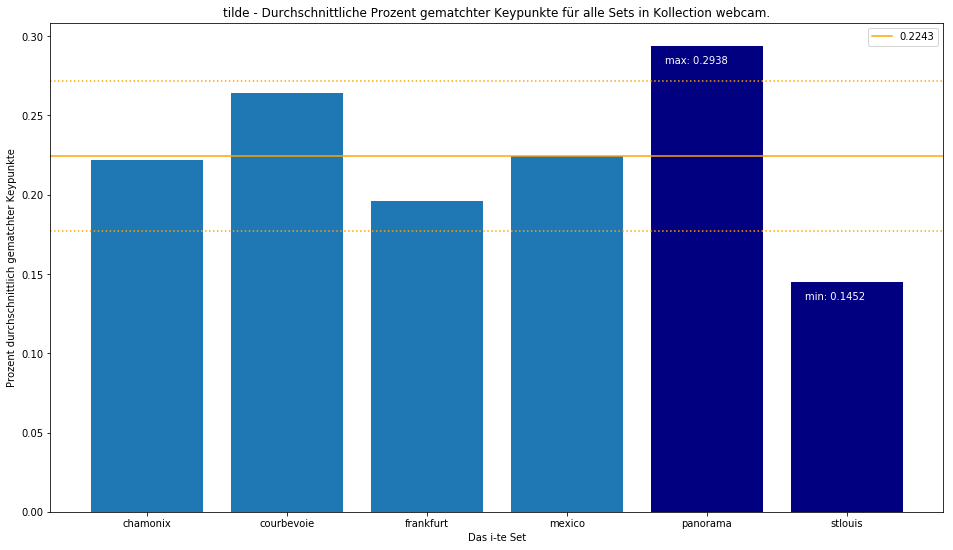

In [67]:
plot_collection__stats_perc_matching_kpts_for_e(collection_name, data, config, fs)

In [68]:
stats_collection__perc_matching_kpts_for_e(collection_name, data, config, fs)

tilde: webcam
durchschnittliche Prozent an gematchen Keypunkten:		0.22+/-0.05
max. Prozent gematchter Keypunkte:		 0.2938003
min. Prozent gematchter Keypunkte:		 0.14517114
Anzahl an Extrema:				 2
	davon oberhalb Standardabweichung:	 1
	davon unterhalb Standardabweichung:	 1
